TO DO:
- Comparaison between HF (Koopman) and MOM ? Add tdm with MOM coeff
- add function to automatize line broadening
- stress more on the link to chemical bond
- break down question 6)

# Chemical sensitivity in carbon K edge spectrum


## Prerequisit
- Quantum mechanics
  - single particle function
  - eigenvector and eigenvalue
- Hartree Fock theory basics
  - MO, AO and electronic configuration
  - Koopman`s excitation
- Absorption/Emission spectroscopy basics
  - transition moment 
  - selection rule
- Python basics

## Forewords

In this module, you will use a quantum chemistry program to: 

- calculate electron binding energies of core **electron**
- calculate excited states properties using Hartree-Fock orbitals
- plot an X-ray emission/absorption spectrum
- investigate the chemical sensitivity of the carbon K-edge spectra
- study the effect of orbital relaxation on the spectrum

The quantum chemistry module that is used is PySCF (\url{https://sunqm.github.io/pyscf/}). You will not directly deal with PySCF's syntax but rather use a class that will allow you to perform the needed calculations and extract the results through a simplified syntax. An example with the CO molecule is provided. 

The questions have been highlighted in green, red and blue, with the following meaning:
- green: the answer does not have to appear in the report.
- blue: these question involve plotting. They have to appear as figures in the report, along with a caption, legend and axis title. In addition, a short discription of the observed features must be given.
- red: an written answer must be given.   

## Sub-routine

The relevant class and functions are given below, there is no need to go through it but an interested reader will find extended comments to understand the content.

In [1]:
import pyscf
import numpy as np
from pyscf import scf,gto
import matplotlib.pyplot as plt


/Users/milaimkas/Teaching/Teaching_project/venv/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
# Molecule object
class Molecule:
    def __init__(self, name_molecule):
      
        '''
          Wrapper class for PySCF mol, hf, MOM and CIS
          initialize molecule and perform Hartree Fock and MOM calculation with the Gaussian 6-31g basis set
          arg:
          - name_molecule = 'CO', 'HNO', 'CNH5', 'CH4', 'CO2', 'CH2O', 'C2H6', 'C2H4', 'C2H2'
        '''
      
        # Define molecular geometry for several compounds
        self.mol       = pyscf.gto.Mole() 
        if name_molecule == 'CO':
          self.mol.atom  = '''
          C 0. 0. 0.
          O 0. 0. 1.147 
          ''' 
        elif name_molecule == 'HNO':
          self.mol.atom = '''
          H  -0.938530   0.9102970  0.0000000
          N  0.0625690   0.5847110  0.0000000
          O  0.0625690  -0.6254090  0.0000000 
          '''
        elif name_molecule == 'CO2':
          self.mol.atom = '''
          C  0.  0.  0.
          O  0.  0.  -1.16
          O  0.  0.  1.16
          '''
        elif name_molecule == 'CH2O':
          self.mol.atom = '''
          O  0.0000000  0.0000000    0.6840550
          C  0.0000000  0.0000000   -0.5377120
          H  0.0000000  0.9482250   -1.1230830
          H  0.0000000  -0.9482250  -1.1230830
          '''
        elif name_molecule == 'C2H2':
          self.mol.atom = '''
          C	0.0000000	0.0000000	0.6146230
          C	0.0000000	0.0000000	-0.6146230
          H	0.0000000	0.0000000	1.6926020
          H	0.0000000	0.0000000	-1.6926020
          '''
        elif name_molecule == 'C2H6':
          self.mol.atom = '''
          C	0.0000000	0.0000000	0.7696050
          C	0.0000000	0.0000000	-0.7696050
          H	0.0000000	1.0302260	1.1677980
          H	-0.892202	-0.515113	1.1677980
          H	0.8922020	-0.515113	1.1677980
          H	0.0000000	-1.030226	-1.1677980
          H	-0.892202	0.5151130	-1.1677980
          H	0.8922020	0.5151130	-1.1677980
          '''
        elif name_molecule == 'C2H4':
          self.mol.atom = '''
          C	0.0000000	0.0000000	0.6770110
          C	0.0000000	0.0000000	-0.6770110
          H	0.0000000	0.9347540	1.2488340
          H	0.0000000	-0.934754	1.2488340
          H	0.0000000	-0.934754	-1.2488340
          H	0.0000000	0.9347540	-1.2488340
          '''
        elif name_molecule == 'CNH5':   
          self.mol.atom = '''
          C	0.05079000	0.7054590	0.0000000
          N	0.05079000	-0.758502	0.0000000
          H	-0.9425740	1.1646480	0.0000000
          H	0.58943700	1.0605680	0.8772540
          H	0.58943700	1.0605680	-0.8772540
          H	-0.4482880	-1.104511	-0.8089300
          H	-0.4482880	-1.104511	0.8089300
          '''   
        else:
          print('Molecule not found in library')
        
        # define gaussian basis set
        self.mol.basis = '''6-31g'''
        # use symmetry     
        self.mol.symmetry = True
        # no output
        self.mol.verbose = 0
        # build one and two electron integrals
        self.mol.build()
        
        # do Restricted Hartree Fock calculation
        # results are stored in the object mf
        self.mf = pyscf.scf.RHF(self.mol)
        self.mf.kernel()
        # store occupation numbers
        self.occ = self.mf.mo_occ

    
    def MO_energy(self):
       '''
       print Hartree Fock MO energies
       '''
       return self.mf.mo_energy

    def print_MO(self):
       '''
       print information on the Hartree Fock MO
       '''
       self.mf.analyze(verbose=5)
    
    def tdm(self,i,a):
        '''
        calculates 
        - the tdm between two MOs "i" and "a"
        where "i" is occupied and "a" virtual MO
        - the oscillator strength relate to that transition
        '''

        # tdm in x,y and z direction for all given MO transition
        tdm = np.zeros((3))
        osci = 0

        # dipole integrals in AOs basis set for the 3 cartesians components
        with self.mol.with_common_orig((0, 0, 0)):
            ao_dip  = self.mol.intor_symmetric('int1e_r', comp=3)
        
        
        tdm[0] = np.einsum('j,k,jk', self.mf.mo_coeff[:, i], self.mf.mo_coeff[:, a].conj(), ao_dip[0])
        tdm[1] = np.einsum('j,k,jk', self.mf.mo_coeff[:, i], self.mf.mo_coeff[:, a].conj(), ao_dip[1])
        tdm[2] = np.einsum('j,k,jk', self.mf.mo_coeff[:, i], self.mf.mo_coeff[:, a].conj(), ao_dip[2])

        osci += (2/3)*abs(self.mf.mo_energy[a]-self.mf.mo_energy[i])
        osci *= np.sum(abs(tdm)**2)

        return tdm, osci   

    def MOM(self,i,a):
          '''
          Maximal overlap calculation for a i --> a excited determinant
          '''
          # define excited singlet occupation for alpha spin
          occ = np.zeros((2, self.occ.size))
          occ[:, self.occ==2] = 1
          occ[1][a] = 1 # virtual orbital a
          occ[1][i] = 0 # occupied orbital i
          occ_es = occ[0][:] + occ[1][:]
          # store mo coefficients in ROHF format
          mo_coeff = self.mf.mo_coeff.copy()
          # new SCF calculation
          es_hf = scf.ROHF(self.mol)
          # construct new density matrix with excited occ vector
          dm_es = es_hf.make_rdm1(mo_coeff, occ_es)
          # Apply mom occupation principle
          es_hf = scf.addons.mom_occ(es_hf, mo_coeff, occ)
          # Start new SCF with new density matrix
          es_hf.scf(dm_es)
          
          # excitation energy
          Ex_ene = es_hf.e_tot - self.mf.e_tot  

          # new MOs energy
          #MO_ene  = es_hf.mo_energy

          return Ex_ene



## Theory


### **Mean field approach for the ground state**

Different approaches are used in order to explicitly treat multi-electron systems. Most of them are based on expansion over single particle functions. These single particle functions are eigenfunctions of some one-electron operator where the explicit coupling (or correlation) between the particles (here electrons) is neglected. The most common approach is the Hartree-Fock method were the interaction between the electrons is approximated as a mean field. An Hartree-Fock calculation produces a set of single-particle function $\phi_i$ (also called molecular orbitals: MOs) that are expressed as linear combination of basis functions $\chi_{j}$ which are referred to as atomic orbitals (AOs):

$$ \phi_i = \sum^{N_{basis}}_{j} c_{ij}\chi_{j}$$

$N_{basis}$ is the size of the AO basis and $c_{ij}$ are the optimized coefficients, usually called molecular orbital coefficients.
The MOs are separated into occupied orbitals, characterized by negative energy, and unoccupied orbitals (positive energy). They are eigenfunctions of the Fock operator (see Chapter $8.7-8.8$ of the lecture notes) <br><br>

### **Treatment of excited states**

An accurate treatment of excited states involves expansion of the wave function unto basis of determinant or time-dependent approaches. Here we will deal with excited states using a much simpler (and faster) method. 
In the Hartree-Fock (HF) method, an approximation of excitation energy can be obtained by taking the sum of the absolute value of the two MOs energy involved in the transition. This is usually referred to as Koopman's theorem. 

For example the first valence excited states of a molecule is usually characterize by a single excitation from the HOMO (highest occupied molecular orbital) to the LUMO (lowest unoccupied molecular orbital).
In the CO molecule, within a define basis set, the LUMO has an energy of $0.154$ au and the HOMO has an energy of $-0.545$ au. The excitation energy associated to this HOMO --> LUMO transition is therefore $abs(-0.545)+abs(0.154)=0.699$ au

One should be aware that this crude approximation neglects many effects: electron correlation and orbital relaxation among others. Even a quantitative excitation energy is rarely obtained. For example, the relaxation correction to this model can be quite big with around 15eV for C, 1 eV for N and 0.2 eV for Oxygen (Stohr J., NEXAFS Spectroscopy, Springer, 1996, pp 22). <br><br>

### **K-edge spectrum**

K-edge spectrum refers to a spectrum obtained when a X-Ray light excites a $1s$ inner core orbital. The resulting excited state may lay below the ionization potential (IP) of the $1s$ orbital, leading to pre-edge and edge spectral lines, or above the IP, leading to above-edge structure. In the one-electron picture, these spectral features arise due to transitions from the 1s core orbital to valence excited MOs.

In the present exercise you will calculate the excitation energies and transition dipole moment of core-to-valence transition for various molecules. The idea is to understand which properties, unique to each molecule, can be retrieved by means of X-ray spectroscopy. <br><br>

### **Spectral line intensity**

The height of a spectral line is proportional to the transition moment between the two states involved in the transition. Different quantities are used to characterize the intensity of a transition. The oscillator strength can be define as:

$$f_{ik}=\frac{2}{3}\frac{\Delta E}{g_i} \sum_{\alpha}|<\Psi_k|\hat{d}_{\alpha}|\Psi_i>|^2$$

where $\Delta E$ is the excitation energy from the initial state $i$ to the final state $k$, $g_i$ is the degeneracy of the initial state and $\hat{d}_{\alpha}$ is $\alpha$ component of the dipole operator. <br><br>

### **Chemical bond**

The chemical bond is the force that held atoms together to form molecules. The strength of a chemical bond $A-B$ can be define by the energy needed to seperate both fragment $A$ and $B$. In many case, the MOs involving valence electrons, hold information on the bonding character (strong, weak , etc) of the molecule.

As an example, the carbon atom can bond to an other carbon via different types of chemical bond: single, double and triple bond. Information of the type of chemical bond can be obtained from the valence MOs (the HOMO and LUMO).



## **Example: Calculating a K-edge spectra of the CO molecule**

### **Step 1: Hartree Fock calculation and analysis of the MOs**

First we create an python object that we call "CO". This object will hold information on the Hartree-Fock results of the CO molecule.

In [3]:
CO = Molecule('CO')

The information of the single particle functions: their energy and composition in terms of atomic orbitals can be obtained from the object 'CO'.

Printed information:
- Total energy for the HF ground state (in au).
- After the header "$****$ MO energy $****$" the occupation and energy of the one-electron function $\phi_i$ (MO #) are shown. For example the first one-electron function is labeled MO #1, it has an energy of around $-20.58$ au and is occupied by two electrons. The point symmetry of the MO is also given, for diatomic molecules they correspond to the usual $\sigma$, $\pi$ notation with: $A1 = \sigma$, $E1x=\pi_x$ and $E1y=\pi_y$. 
- After the header "$**$ MO coefficients (expansion on meta-Lowdin AOs) $**$", the expansion coefficients $c_{ij}$ are given in columns, one for each MO ($\phi_i$). Each row refers to a AOs ($\chi_j$). For example one can see that the MO #1 is mainly composed by the $1s$ AO of oxygen, and the MO #2 is the $1s$ AO of carbon. 
- The  $**$ Mulliken pop on meta-lowdin orthogonal AOs $**$ section gives information on the electronic populations of the single atomic orbitals and on the charge distribution within the molecule.

In [4]:
CO.print_MO()

**** SCF Summaries ****
Total Energy =                        -112.666599766068487
Nuclear Repulsion Energy =              22.145166629607672
One-electron Energy =                 -197.115458973601562
Two-electron Energy =                   62.303692577925418
Wave-function symmetry = Coov
occupancy for each irrep:     A1  E1x  E1y
                               5    1    1
**** MO energy ****
MO #1 (A1 #1), energy= -20.6863637669333 occ= 2
MO #2 (A1 #2), energy= -11.4029546234066 occ= 2
MO #3 (A1 #3), energy= -1.54740479404474 occ= 2
MO #4 (A1 #4), energy= -0.795961432315602 occ= 2
MO #5 (E1x #1), energy= -0.634418637982632 occ= 2
MO #6 (E1y #1), energy= -0.634418637982632 occ= 2
MO #7 (A1 #5), energy= -0.552519146745796 occ= 2
MO #8 (E1x #2), energy= 0.135235290806966 occ= 0
MO #9 (E1y #2), energy= 0.135235290806964 occ= 0
MO #10 (A1 #6), energy= 0.402938743400854 occ= 0
MO #11 (E1x #3), energy= 0.727847811784466 occ= 0
MO #12 (E1y #3), energy= 0.727847811784466 occ= 0
MO #13 (A1 #7),

The MOs energy (given in au) can be direclty access and store into an array using the following function


In [5]:
print(CO.MO_energy())

[-20.68636377 -11.40295462  -1.54740479  -0.79596143  -0.63441864
  -0.63441864  -0.55251915   0.13523529   0.13523529   0.40293874
   0.72784781   0.72784781   0.76956122   0.9955472    1.1909798
   1.20533767   1.20533767   1.83706481]


You can see that there are 7 and 11 occupied and unoccupied MOs, respectively

### **Step 2: getting the excitation energies**

#### Koopman`s excitation


Let us now calculate the oxygen core-to-valence excitation energies in CO.

The first MOs corresponds to the $1s$ AO of O. Within our basis set, the LUMO has an energy of $0.1537$ au and the $1s_O$ MOs has an energy of $-20.58$ au (see previous point). The excitation energy associated to this $1s_O$ --> LUMO transition is: 

In [8]:
DE_CO_O = np.zeros((5))
DE_CO_O[0] = abs((CO.MO_energy()[7]-CO.MO_energy()[0])) 
print(DE_CO_O[0])

20.821599057740304


Higher core excitation energies are obtained by "promoting" the $1s_O$ electron to higher virtual orbitals. The obtained serie of excitation energies corresponds to the K edge of oxygen in CO.  

In [9]:
for i in range(5):
  DE_CO_O[i]=abs(CO.MO_energy()[7+i]-CO.MO_energy()[0])

print(DE_CO_O) # in au
print(DE_CO_O*27.2114) # in eV

[20.82159906 20.82159906 21.08930251 21.41421158 21.41421158]
[566.5848606  566.5848606  573.86944633 582.71067695 582.71067695]


Note that whithin this approximation, the calculated excitation energies are larger than the Koopman's ionization potential (IP) of the $1s_O$ orbital ($20.58$ au). 

#### Including orbital relaxation


In order to get better excitation energies, one can use the maximal overlap method (MOM, see *T. B. Gilbert et al, J. Phys. Chem. A 2008, 112, 50, 13164*) that account for orbital relaxation. 

In [10]:
DE_CO_O_MOM = np.zeros((5))
for i in range(5):
  DE_CO_O_MOM[i]=CO.MOM(0,7+i)

print(DE_CO_O_MOM)
print(DE_CO_O_MOM*27.2114)

[19.67754425 19.67754425 20.05471035 20.34553497 20.34553497]
[535.45352761 535.45352761 545.71674508 553.63049019 553.63049019]


As you can see, the difference in excitation energy is around 30 eV ! In addition or improved excitation energies are now below the IP of the $1s_O$ orbital.

<font color='green'> **1) Calculate the carbon K-edge in CO (calculate the 5 first core-to-valence excitation energies)**

hint: follow the same procedure as above but use the $1s$ orbital of carbon instead of oxygen

In [11]:
DE_CO_C = np.zeros((5))
for i in range(5):
  DE_CO_C[i]=abs(CO.MO_energy()[7+i]-CO.MO_energy()[1])

print(DE_CO_C*27.2114)

[313.97030103 313.97030103 321.25488676 330.09611738 330.09611738]


### **Step 3: getting the transition dipole moment**


Transition dipole moment and oscillator strength can be extracted for a given pair of occupied/virtual MO. This is done using the $tdm$ function: $CO.tdm(i,a)$ which returns the three cartesian components of the transition dipole moment and the oscillator strength for a $i$ --> $a$ transition. 

For the $1s_O$ --> LUMO transition:



In [12]:
print(CO.tdm(0,7)[0]) # transition dipole moment
print()
print(CO.tdm(0,7)[1]) # oscillator strength

[-0.03108124  0.          0.        ]

0.013409713214897635


<font color='green'> **2) Calculate the transition dipole moments and oscillator strength for the transistion calculated in 1).**


In [13]:
tdm_CO = np.zeros((5,3))
OS_CO = np.zeros((5))

for i in range(5):
   a = 7+i   
   tdm_CO[i,:],OS_CO[i] = CO.tdm(1,a)

print(tdm_CO)
print(OS_CO)

[[ 0.05723355  0.          0.        ]
 [ 0.          0.05723355  0.        ]
 [ 0.          0.         -0.00875774]
 [-0.09234176  0.          0.        ]
 [ 0.         -0.09234176  0.        ]]
[0.02519694 0.02519694 0.00060366 0.06895958 0.06895958]


<font color='blue'>**3a) Plot the X-Ray absorption spectrum at the C K-edge of CO using the excitation energies and oscillator strength obtained in 1) and 2).**

hint i : plot vertical lines using the $plt.vlines()$ function. <br>
hint ii: the position of the line is the excitation energy while the height can be given by the oscillator strength. <br>

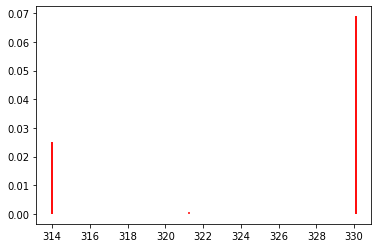

In [14]:
# plot lines
for i in range(5):
    plt.vlines(DE_CO_C[i]*27.2114,0,OS_CO[i],colors='r')
    #plt.vlines(DE_CO_C[i]*27.2114,0,sum(abs(tdm_CO[i])**2),colors='r')

plt.show()

<font color='blue'>**3b) Plot the X-Ray absorption spectrum at the O K-edge of CO.**

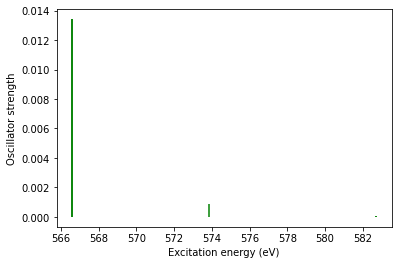

In [15]:
OS_CO_O = np.zeros(5)
for i in range(5):
    OS_CO_O[i] = CO.tdm(0,7+i)[1]


plt.xlabel('Excitation energy (eV)')
plt.ylabel('Oscillator strength')  
plt.vlines(DE_CO_O*27.2114,0,OS_CO_O,colors='green')
plt.show()

<font color='brown'>**3c) In points 3a and 3b we have plotted the oscillator strengths relative to 5 excitations. Why do we see only three lines in the plotted spectra? In both the O and C K-edge the final orbitals are the same. Comparing the two spectra you can see that, the oscillator strenghts of the transitions with the same final MO is however very different both in absolute value and relative intensity distribution. Why is it so?**

hint: think about the composition of the MOs in terms of AOs.

### **Step 4: Include line broadening**



In a real spectrum, the spectral lines always have a finite, non-zero width. This is reffered to as line broadening and arises from different effects, such as : 

- Natural broadening (related to the time-energy uncertainity principle) 
- Collision broadening
- Doppler effect

the two first effects are related to the finite life-time of the excited states. The first case arises from the intrinsic finite life-time (coupling with the field or other states) and the second is due to collision-induced decay (in a gas for example). One can define a phenomenological decay probability $\Gamma$, which is related to the life-time $\tau$ by $\Gamma=1/\tau$, that account for all possible decay channel. In the following, $\Gamma$ is considered to be the FWHM (full width at half maximum) of the line. 

The line shape related to the finite life-time is given by a Lorentzian function:

$$ g(E) = \frac{(\Gamma/2)^2}{(E_0-E)^2+(\Gamma/2)^{2}} $$

where $E_0$ is the excitation energy. A typical life-time for a bound valence electronic transition is $10^{-8}s$ while core excited states have shorter life-time, in the order of $10^{-15}s$.

$1fs=10^{-15}s=41.34$ au



<font color='blue'>**4) Use the last given expression to simulate a more realistic C K-edge spectrum for CO by adding the line broadening to the vertical lines.**

hint i: use the results you got in 3a) and 3b) <br>
hint ii: one is usualy not interested in absolute value for the line intensities, only in the ratio. Normalize your lines with respect to the most intense transition. 

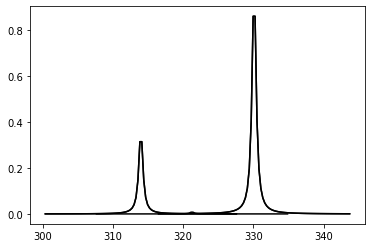

In [16]:
def gE(E0,E,tau):
   
   gamma = 1/tau
   g = (gamma/2)**2/((E0-E)**2 + (gamma/2)**2)

   return g

OS_CO /= max(OS_CO)

fE_points = 0
for i in range(5):
    E_ini = (DE_CO_C[i])-0.5
    E_fin = (DE_CO_C[i])+0.5
    E_points = np.linspace(E_ini,E_fin,100)
    fE_points = gE(DE_CO_C[i],E_points,40)*OS_CO[i]

    plt.plot(E_points*27.2114,fE_points,'k')


## **Carbon K-edge spectra for various molecules containing carbon atoms**

<font color='brown'>**5) Extract the binding energy of the $1s_C$ orbital for the C2H2, C2H4 and C2H6 molecules. How do they compare ? How would you explain it ?**

hint: follow the procedure given above for CO
- step 1: create a Molecule object and analyze the MOs, identify the $1s_C$ and the unoccupied MOs

In [71]:
C2H6 = Molecule('C2H6')
C2H4 = Molecule('C2H4')
C2H2 = Molecule('C2H2')

In [72]:
print('C2H2 MOs energies')
print(C2H2.MO_energy())
print()
print('C2H4 MOs energies')
print(C2H4.MO_energy())
print()
print('C2H6 MOs energies')
print(C2H6.MO_energy())

C2H2 MOs energies
[-11.25515096 -11.25202359  -1.02326713  -0.75484512  -0.66841987
  -0.39853299  -0.39853299   0.20475448   0.20475448   0.24171128
   0.29030878   0.60277463   0.66520591   0.76002545   0.76002545
   0.89958133   0.89958133   0.9663349    1.05152287   1.28021769
   1.52918506   1.78905533]

C2H4 MOs energies
[-11.23905819 -11.23757647  -1.02616377  -0.78607763  -0.63494319
  -0.57824604  -0.49910125  -0.36791951   0.16948963   0.25954316
   0.28586071   0.30048539   0.3869788    0.48280834   0.68883178
   0.78672069   0.78716906   0.88480109   0.89564421   0.97736989
   1.1409982    1.18440466   1.21559237   1.22744011   1.36357261
   1.50690855]

C2H6 MOs energies
[-11.21953063 -11.21899065  -1.01596992  -0.84036804  -0.59263107
  -0.59263107  -0.5048752   -0.48124342  -0.48124342   0.23822796
   0.29605924   0.30903531   0.30903532   0.33314863   0.33314863
   0.40169895   0.74371653   0.76345751   0.76345754   0.87003622
   0.87003624   0.9434161    1.19446121   1

In [80]:
print('1s_C binding energies in au and eV')
print('C2H2:', C2H2.MO_energy()[0],C2H2.MO_energy()[0]*27.2114)
print('C2H4:', C2H4.MO_energy()[0],C2H4.MO_energy()[0]*27.2114)
print('C2H6:', C2H6.MO_energy()[0],C2H6.MO_energy()[0]*27.2114)

1s_C binding energies in au and eV
C2H2: -11.255150956296001 -306.268414732153
C2H4: -11.239058194261343 -305.83050814732314
C2H6: -11.219530633774667 -305.299135887896


<font color='blue'>**6) Calculate and plot a C K-edge spectrum for the C2H2, C2H4 and C2H6 molecules**

hint i: follow the steps given in the CO example
- step 2: store the core-to-valence excitation energies for 5 transitions
- step 3: store the oscillator strength for the 5 transitions
- step 4: add the line broadening 

hint ii: when plotting the final spectrum, you will have to add the spectra of each molecule.

hint iii: do not forget to normalize you final spectrum (with respect to the most intense line).

In [75]:
# step 2
DE_C2H2 = np.zeros((5))
for i in range(5):
  DE_C2H2[i]=abs(C2H2.MO_energy()[7+i]-C2H2.MO_energy()[1])

DE_C2H4 = np.zeros((5))
for i in range(5):
  DE_C2H4[i]=abs(C2H4.MO_energy()[8+i]-C2H4.MO_energy()[0])

DE_C2H6 = np.zeros((5))
for i in range(5):
  DE_C2H6[i]=abs(C2H6.MO_energy()[9+i]-C2H6.MO_energy()[0])



In [76]:
# step 3

# initialize tdm and OS array
tdm_C2H2 = np.zeros((5,3))
OS_C2H2 = np.zeros((5))
tdm_C2H4 = np.zeros((5,3))
OS_C2H4 = np.zeros((5))
tdm_C2H6 = np.zeros((5,3))
OS_C2H6 = np.zeros((5))

for i in range(5):   
   tdm_C2H2[i,:],OS_C2H2[i] = C2H2.tdm(0,i+7)
   tdm_C2H4[i,:],OS_C2H4[i] = C2H4.tdm(1,i+8)
   tdm_C2H6[i,:],OS_C2H6[i] = C2H6.tdm(0,i+9)

OS = np.concatenate((OS_C2H2,OS_C2H4,OS_C2H6))
# normalize
ref = max(OS)
OS_C2H2 /= ref
OS_C2H4 /= ref
OS_C2H6 /= ref

for i in range(5):
    plt.vlines(DE_C2H2[i]*27.2114,0,OS_C2H2[i],colors='k')
    plt.vlines(DE_C2H4[i]*27.2114,0,OS_C2H4[i],colors='r')
    plt.vlines(DE_C2H6[i]*27.2114,0,OS_C2H6[i],colors='b')

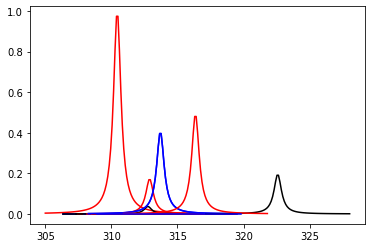

In [79]:
# step 4

tau = 40
Emin = 0.2
Emax = 0.2
E_grid =100

for i in range(5):

    E_ini = (DE_C2H2[i])-Emin
    E_fin = (DE_C2H2[i])+Emax
    E_points = np.linspace(E_ini,E_fin,E_grid)
    fE_points = gE(DE_C2H2[i],E_points,tau)*OS_C2H2[i]
    plt.plot(E_points*27.2114,fE_points,'k')

    E_ini = (DE_C2H4[i])-Emin
    E_fin = (DE_C2H4[i])+Emax
    E_points = np.linspace(E_ini,E_fin,E_grid)
    fE_points = gE(DE_C2H4[i],E_points,tau)*OS_C2H4[i]
    plt.plot(E_points*27.2114,fE_points,'r')

    E_ini = (DE_C2H6[i])-Emin
    E_fin = (DE_C2H6[i])+Emax
    E_points = np.linspace(E_ini,E_fin,E_grid)
    fE_points = gE(DE_C2H6[i],E_points,tau)*OS_C2H6[i]
    plt.plot(E_points*27.2114,fE_points,'b')
 
#plt.xlim([305,327])
#plt.ylim([0,0.2])
plt.show()

<font color='brown'>**7) Could you use these spectral lines to distinguish the different compounds? Considering your observation in point 5), how do you explain the difference in the position and intensity of the spectral lines.  What type of conclusions can you make on the final MOs?**

<font color='brown'>**8) Based on your answer in the previous question, what type of information on the molecule can you retrieve from the spectral analysis?**

<font color='brown'>**9) The spectral lines would also be different in a UV/visible spectra (which involves HOMO --> LUMO transitions). Explain the advantage of using X-ray absorbtion.** 

hint: X-ray involves a core to valence transition 

<font color='brown'>**10) What happens if the life-time of the excited states decreases ? In an experiment, what could cause such increase ?**

<font color='green'>**Bonus: investigate the influence of orbital relaxation using the MOM method on the spectrum obtained in 6)**